# Mutual Information Minimization Demo

This demo is adapted from https://github.com/Linear95/CLUB

In this notebook, we provide a demo for how to use different MI estimators in `mi` folder to minimize mutual information with data under multivariate Gaussian setups. 

In [40]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import utils_os, utils_data

import mi

device = 'cuda:0'

## Dataset

Consider the following data generating process:

$\left[\begin{array}{c} x \\ y \end{array}\right] \sim \mathcal{N}\left(\left[\begin{array}{c} 0\\0\end{array}\right], \left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] \right) $

Our goal is to minimise the parameter $\rho$ to minimize the mutual information $I(x, y)$ between $x$ and $y$ with samples $\mathcal{D}=  \{x^{(i)}, y^{(i)}\}^n_{i=1}$. Note that this happens when $\rho = 0$. 

In order to optimise $\rho$, we consider parameterizing the covariance matrix by $\left[\begin{array}{cc} 1 &\rho \\ \rho & 1\end{array} \right] = {SS}^T$ with $S =\left[\begin{array}{cc} \cos \theta &\sin \theta \\ \sin \theta & \cos \theta \end{array} \right]$. Then we have $\left[\begin{array}{c} x \\ y \end{array}\right] = Sz, z \sim \mathcal{N}(z; 0, \mathbf{I})$. We can now instead optimise $\theta$.

In [36]:
class GaussianSampler(nn.Module):
    def __init__(self, dim=2, para_list = None):
        super(GaussianSampler, self).__init__()
        self.dim = dim
        if para_list is None:
            para_list = [0.55] * dim
        self.p_theta_ = torch.nn.Parameter(torch.tensor(para_list, requires_grad = True))
        
    def get_trans_mat(self):
        p_theta = self.p_theta_.cuda().unsqueeze(-1)

        trans_row1 = torch.cat((torch.sin(p_theta),torch.cos(p_theta)), dim=-1).unsqueeze(-1)
        trans_row2 = torch.cat((torch.cos(p_theta),torch.sin(p_theta)), dim=-1).unsqueeze(-1)  #[dim, 2,1]
        return torch.cat((trans_row1, trans_row2), dim=-1)  #[dim,2,2]

    def gen_samples(self, num_sample, cuda = True):
        noise= torch.randn(self.dim,num_sample,2).cuda()
        trans_mat = self.get_trans_mat()
        samples = torch.bmm(noise, trans_mat).transpose(0,1) #[dim, nsample, 2]
        if not cuda:
            samples = samples.cpu().detach().numpy()
        return samples[:,:,0], samples[:,:,1]

    def get_covariance(self):
        p_theta = self.p_theta_.cuda()
        return (2.*torch.sin(p_theta)*torch.cos(p_theta))

    def get_MI(self):
        rho = self.get_covariance()
        return -1./2.*torch.log(1-rho**2).sum().item()

We can plot the sample pairs of variable $x$ and $y$, which initially has a high linear correlation.

The corvariance of Gaussian is [0.8912074 0.8912074]


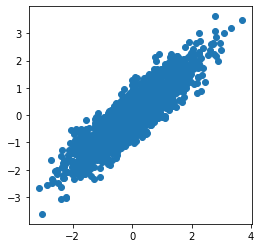

In [10]:
sampler = GaussianSampler().cuda()
print("The corvariance of Gaussian is {}".format(sampler.get_covariance().cpu().detach().numpy()))
x_sample, y_sample = sampler.gen_samples(1000, cuda = False)
plt.figure(figsize=(4, 4))
plt.scatter(x_sample, y_sample)
plt.show()

We may further apply an one-to-one mapping $g(\cdot)$ to $y$ to make the distributions $p(x, y)$ non-Gaussian (and hence a more challeging task). Note that this does not change MI: $I(x. g(y)) = I(x, y)$. 

Try different $g$ below to see what happens to different methods.

In [11]:
def g1(y):    # linear mapping
    return y
    
def g2(y):    # nonlinear mapping, where z = [e(Ay), tanh(Ay)] 
    A = torch.Tensor([[1, 1.5], [1.5, 1]]).to(y.device)
    q = torch.matmul(y, A)
    z = torch.zeros(y.size()).to(y.device)
    z[:, 0] = q[:, 0].exp()
    z[:, 1] = torch.tanh(q[:, 1])
    return z

g = g2

## Slice 

Proposed method for minimising MI without estimating its value. See https://openreview.net/pdf?id=Ojakr9ofova

In [37]:
# hyperparams
class Hyperparams(utils_os.ConfigDict):
    def __init__(self): 
        self.lr = 1e-3
        self.bs = 250
        self.n_slice = 50               # <-- we can tune this to adjust performance
hyperparams=Hyperparams()

# dataset
sampler = GaussianSampler(sample_dim).cuda()
sampler_optimizer = torch.optim.Adam(sampler.parameters(), lr = hyperparams.lr)

# estimator for I(x, y)
mi_estimator = mi.SliceInfominLayer([sampler.dim, hyperparams.n_slice, sampler.dim], hyperparams=hyperparams).to(device)

mi_true_values, mi_est_values, min_mi = [], [], 100.
for i in range(1500):
    # sample a mini-batch
    sampler.train()
    x_samples, y_samples = sampler.gen_samples(hyperparams.bs)
    
    # max-step (estimate sliced MI)
    xx_samples, yy_samples = sampler.gen_samples(2500)
    t0 = time.time()
    si_loss_train, si_loss_val = mi_estimator.learn(xx_samples, g(yy_samples))       
    t1 = time.time()
    
    # min-step (minimise sliced MI)
    sampler_loss = mi_estimator.objective_func(x_samples, g(y_samples))
    sampler_optimizer.zero_grad()
    sampler_loss.backward() 
    sampler_optimizer.step()

    mi_estimator.mode = 'eval'
    mi_true_values.append(sampler.get_MI())
    mi_est_values.append(si_loss_val)
    if i % 100 ==0:
        print("step {}, true MI value {}".format(i, sampler.get_MI()), ',', 'est slice MI (in [0, 1])', si_loss_val, 'time used', t1-t0)

step 0, true MI value 1.573256492614746 , est slice MI (in [0, 1]) 0.8647175431251526 time used 0.025267601013183594
step 100, true MI value 0.9293259382247925 , est slice MI (in [0, 1]) 0.7598481774330139 time used 0.013947010040283203
step 200, true MI value 0.4796763062477112 , est slice MI (in [0, 1]) 0.6544042229652405 time used 0.013683795928955078
step 300, true MI value 0.1954234391450882 , est slice MI (in [0, 1]) 0.3533746004104614 time used 0.014057397842407227
step 400, true MI value 0.05338826775550842 , est slice MI (in [0, 1]) 0.21423791348934174 time used 0.014408111572265625
step 500, true MI value 0.011127153411507607 , est slice MI (in [0, 1]) 0.06628256291151047 time used 0.014258623123168945
step 600, true MI value 0.006094732321798801 , est slice MI (in [0, 1]) 0.021607117727398872 time used 0.014864683151245117
step 700, true MI value 0.005425619892776012 , est slice MI (in [0, 1]) 0.034009359776973724 time used 0.009132146835327148
step 800, true MI value 0.0030

### Visualise the learning dynamics

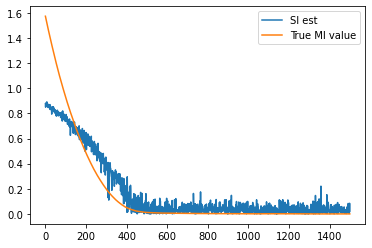

In [31]:
plt.plot(np.arange(len(mi_est_values)), mi_est_values, label='SI' + " est")
plt.plot(np.arange(len(mi_true_values)), mi_true_values, label="True MI value")
plt.legend()
plt.show()

### Visualise the optimised Gaussian sampler

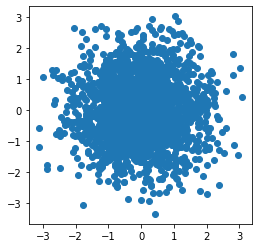

In [32]:
x_sample, y_sample = sampler.gen_samples(1000, cuda=False)
plt.figure(figsize=(4, 4))
plt.scatter(x_sample, y_sample)
plt.show()

one can see that there is no correlation between x and y. 

## CLUB

State-of-the-art method for minimising MI based on minmax learning and variational distribution. See https://arxiv.org/abs/2006.12013

In [41]:
# hyperparams
class Hyperparams(utils_os.ConfigDict):
    def __init__(self): 
        self.lr = 1e-3
        self.inner_lr = 1e-3
        self.bs = 250
hyperparams=Hyperparams()

# dataset
sampler = GaussianSampler().cuda()
sampler_optimizer = torch.optim.Adam(sampler.parameters(), lr = hyperparams.lr)

# estimator for I(x, y)
mi_estimator = mi.ClubInfominLayer(dim_z=sampler.dim, dim_y=sampler.dim, hidden_size=50, hyperparams=hyperparams).to(device)
mi_optimizer = torch.optim.Adam(mi_estimator.parameters(), lr = hyperparams.inner_lr)

mi_true_values, mi_est_values, min_mi = [], [], 100.
for i in range(1500):
    # sample a mini-batch
    sampler.train()
    x_samples, y_samples = sampler.gen_samples(hyperparams.bs)
    
    # max-step (estimate MI)
    t0 = time.time()
    for j in range(5):                                                   
        mi_estimator.train()
        xx_samples, yy_samples = sampler.gen_samples(hyperparams.bs)
        mi_estimator.mode = 'learn'
        mi_loss = -mi_estimator.objective_func(xx_samples, g(yy_samples))
        mi_optimizer.zero_grad()
        mi_loss.backward()
        mi_optimizer.step()
    t1 = time.time()
    
    # min-step (minimise MI)
    sampler_loss = mi_estimator(x_samples, g(y_samples))
    sampler_optimizer.zero_grad()
    sampler_loss.backward() # retain_graph=True)
    sampler_optimizer.step()

    mi_estimator.mode = 'eval'
    mi_true_values.append(sampler.get_MI())
    mi_est_values.append(mi_estimator(x_samples, y_samples).item())
    if i % 100 ==0:
        print("step {}, true MI value {}".format(i, sampler.get_MI()), 'est MI', mi_est_values[i], 'time used per inner loop', t1-t0)

step 0, true MI value 1.58111572265625 est MI -0.3790648281574249 time used per inner loop 0.025545835494995117
step 100, true MI value 1.7146694660186768 est MI 2.483916997909546 time used per inner loop 0.03326845169067383
step 200, true MI value 1.6145074367523193 est MI 3.1436421871185303 time used per inner loop 0.03309798240661621
step 300, true MI value 1.4802472591400146 est MI 2.5368003845214844 time used per inner loop 0.03241109848022461
step 400, true MI value 1.45615816116333 est MI 2.7624151706695557 time used per inner loop 0.033078670501708984
step 500, true MI value 1.4465115070343018 est MI 2.4377331733703613 time used per inner loop 0.03285956382751465
step 600, true MI value 1.4407196044921875 est MI 2.299938678741455 time used per inner loop 0.03305482864379883
step 700, true MI value 1.3987538814544678 est MI 2.298882007598877 time used per inner loop 0.0322415828704834
step 800, true MI value 1.3905118703842163 est MI 1.7813917398452759 time used per inner loop 0

### Visualising the learning dynamics

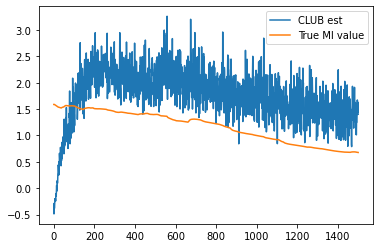

In [18]:
plt.plot(np.arange(len(mi_est_values)), mi_est_values, label='CLUB' + " est")
plt.plot(np.arange(len(mi_true_values)), mi_true_values, label="True MI value")
plt.legend()
plt.show()

### Visualise the optimised Gaussian sampler

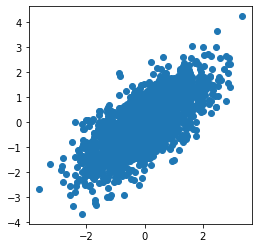

In [19]:
x_sample, y_sample = sampler.gen_samples(1000, cuda=False)
plt.figure(figsize=(4, 4))
plt.scatter(x_sample, y_sample)
plt.show()

The correlation between $x$ and $y$ is still high when g2 is used